In [2]:
import numpy as np
from pyntcloud import PyntCloud
import open3d as o3d
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

In [3]:
print(o3d.__version__)

0.13.0


In [4]:
def read_point_cloud(file_or_cloud):
    if isinstance(file_or_cloud, PyntCloud):
        return file_or_cloud
    elif isinstance(file_or_cloud, str):
        cloud = PyntCloud.from_file(file_or_cloud)
        return cloud
    else:
        raise ValueError("Input must be a file path (str) or a Point Cloud object.")


In [5]:
def pyntcloud_to_open3d(file_or_cloud):
    cloud = read_point_cloud(file_or_cloud)
    cloud_pts = cloud.points[['x', 'y', 'z', 'intensity']].values

    xyz = cloud_pts[:, :3]
    open3d_cloud = o3d.geometry.PointCloud()
    open3d_cloud.points = o3d.utility.Vector3dVector(xyz)
    return open3d_cloud

In [6]:
def color_pcd(pcd, clr='r'):
    if clr == 'r':
        color = [1, 0, 0]
        pcd.paint_uniform_color(color)
    elif clr == 'g':
        color = [0, 1, 0]
        pcd.paint_uniform_color(color)
    elif clr == 'b':
        color = [0, 0, 1]
        pcd.paint_uniform_color(color)

    return pcd

In [7]:
def visualize_multiple_pcds(*pcds, normal=False):
    clouds = [pcd for pcd in pcds if isinstance(pcd, o3d.geometry.PointCloud)]
    o3d.visualization.draw_geometries(clouds, point_show_normal=normal)

In [8]:
def visualize_clouds(inlier_cloud, outlier_cloud, normal=False):
    inlier_pcd = pyntcloud_to_open3d(inlier_cloud)
    outlier_pcd = pyntcloud_to_open3d(outlier_cloud)
    
    inlier_pcd = color_pcd(inlier_pcd, 'r')
    
    visualize_multiple_pcds(inlier_pcd, outlier_pcd, normal)

In [9]:
def normals_filter(input_cloud, radius, max_nbs, ang_deg, ort='+z'):
    cloud = read_point_cloud(input_cloud)
    cloud_df = cloud.points
    pcd = pyntcloud_to_open3d(cloud)
    
    pcd.estimate_normals(
        search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=radius, 
                                                          max_nn=max_nbs))
    if ort == 'camera':
        pcd.orient_normals_towards_camera_location()
    elif ort == '+z':
        pcd.orient_normals_to_align_with_direction([0, 0, 1])
    elif ort == '-z':
        pcd.orient_normals_to_align_with_direction([0, 0, -1])

    normals = np.asarray(pcd.normals)
    cos_angle = np.cos(np.radians(ang_deg))
    
    vertical_mask = np.abs(normals[:, 2]) >= cos_angle
    
    # Apply the mask to filter out vertical points
    inlier_df = cloud_df.loc[~vertical_mask].copy()
    outlier_df = cloud_df.loc[vertical_mask].copy()
    
    # Add normal vectors to the DataFrames
    inlier_normals = normals[~vertical_mask]
    inlier_df.loc[:, 'nx'] = inlier_normals[:, 0]
    inlier_df.loc[:, 'ny'] = inlier_normals[:, 1]
    inlier_df.loc[:, 'nz'] = inlier_normals[:, 2]
    
    outlier_normals = normals[vertical_mask]
    outlier_df.loc[:, 'nx'] = outlier_normals[:, 0]
    outlier_df.loc[:, 'ny'] = outlier_normals[:, 1]
    outlier_df.loc[:, 'nz'] = outlier_normals[:, 2]
    
    # Convert DataFrames back to PyntClouds
    inlier_cloud = PyntCloud(inlier_df)
    outlier_cloud = PyntCloud(outlier_df)
    
    return inlier_cloud, outlier_cloud

In [10]:
# def filter_by_normals(pcd, normals, angle_deg):
#     # Calculate the cosine of the angle for comparison
#     cos_angle = np.cos(np.radians(angle_deg))

#     # Determine the range for exclusion based on cosine values
#     vertical_mask = np.abs(normals[:, 2]) >= cos_angle
#     inlier_indices = np.where(~vertical_mask)[0]
#     outlier_indices = np.where(vertical_mask)[0]

#     # Extract inlier and outlier point clouds
#     inlier_pcd = pcd.select_by_index(inlier_indices)
#     outlier_pcd = pcd.select_by_index(outlier_indices)

#     return inlier_pcd, outlier_pcd

In [11]:
def apply_intensity_filter(map_file, filter_range):
    lower, upper = filter_range
    map_cloud = read_point_cloud(map_file)
    map_df = map_cloud.points
    map_points = map_df.values

    intensity_axis = map_points[:, 3]
    intensity_mask = np.logical_and(intensity_axis >= lower, intensity_axis <= upper)

    inlier_points_df = map_df[intensity_mask]
    outlier_points_df = map_df[~intensity_mask]

    # Convert filtered DataFrames back to PyntClouds
    inlier_cloud = PyntCloud(inlier_points_df)
    outlier_cloud = PyntCloud(outlier_points_df)

    return inlier_cloud, outlier_cloud

In [12]:
def segment_plane(input_cloud, dist_thresh, ransac_n, num_iters):
    cloud = read_point_cloud(input_cloud)
    cloud_df = cloud.points
    pcd = pyntcloud_to_open3d(cloud)
    
    # Apply plane segmentation
    plane_model, inliers = pcd.segment_plane(distance_threshold=dist_thresh,
                                             ransac_n=ransac_n,
                                             num_iterations=num_iters)
    
    
    
    inlier_mask = np.zeros(len(pcd.points), dtype=bool)
    inlier_mask[inliers] = True

    # Filtering inlier points based on the mask
    inlier_points_df = cloud_df[inlier_mask]
    outlier_points_df = cloud_df[~inlier_mask]

    # Convert filtered DataFrames back to PyntClouds
    inlier_cloud = PyntCloud(inlier_points_df)
    outlier_cloud = PyntCloud(outlier_points_df)

    return inlier_cloud, outlier_cloud

In [41]:
def visualize_plane(pcd, plane='yz'):
    matrix = np.asarray(pcd.points)
    x = matrix[:, 0]
    y = matrix[:, 1]
    z = matrix[:, 2]
    
    min_x, max_x = np.min(x), np.max(x)
    min_y, max_y = np.min(y), np.max(y)
    min_z, max_z = np.min(z), np.max(z)
    
    colors = z
    cmap = plt.colormaps.get_cmap('nipy_spectral')
    size = 20
    edgecolors='k'
    
    plt.figure(figsize=(10, 6))
    if plane == 'yz':
        plt.scatter(y, z, c=colors, cmap=cmap, s=size, edgecolors=edgecolors)
        plt.xlim(min_y - 1, max_y + 1)
        plt.ylim(min_z - 1, max_z + 1)
        plt.xlabel('Y-Axis')
        plt.ylabel('Z-Axis')
    elif plane == 'xz':
        plt.scatter(x, z, c=colors, cmap=cmap, s=size, edgecolors=edgecolors)
        plt.xlim(min_x - 1, max_x + 1)
        plt.ylim(min_z - 1, max_z + 1)
        plt.xlabel('X-Axis')
        plt.ylabel('Z-Axis')
    elif plane == 'xy':
        plt.scatter(x, y, c=colors, cmap=cmap, s=size, edgecolors=edgecolors)
        plt.xlim(min_x - 1, max_x + 1)
        plt.ylim(min_y - 1, max_y + 1)
        plt.xlabel('X-Axis')
        plt.ylabel('Y-Axis')
    plt.grid(True)
    plt.show()

## Ground Map Logic implementation

In [14]:
ply_frame = '/home/ty/Downloads/AAI/Lane_Marking_Execution/hamburg/maps/ground_map.ply'

In [15]:
RADIUS = 0.5
NBS = 10
ANG = 20

In [16]:
def flow(ply_frame):
    
    INLIER, OUTLIER = normals_filter(ply_frame, RADIUS, NBS, ANG)
    
    return INLIER, OUTLIER


In [17]:
Inlier, Outlier = flow(ply_frame)

In [18]:
# inlier_pcd = '/home/maanz/Downloads/DGV/LidarPipeline_runs/test/inlier_pcd.pcd'
# outlier_pcd = '/home/maanz/Downloads/DGV/LidarPipeline_runs/test/outlier_pcd.pcd'

# o3d.io.write_point_cloud(inlier_pcd, Inlier)
# o3d.io.write_point_cloud(outlier_pcd, Outlier)

In [19]:
visualize_clouds(Inlier, Outlier, True)

## Single Frame Processing

In [20]:
input_frame = '/home/ty/Downloads/AAI/Lane_Marking_Execution/hamburg/preprocessed/frames/1693307425423818163.ply'
# input_pcd = pyntcloud_to_open3d(input_frame)

In [27]:
inlier_cloud, outlier_cloud = segment_plane(input_frame, 0.2, 10, 1000)

In [28]:
visualize_clouds(inlier_cloud, outlier_cloud, False)

In [37]:
inlier_nor_cloud, outlier_nor_cloud = normals_filter(inlier_cloud, 0.05, 3, 10, 'camera')

In [38]:
visualize_clouds(inlier_nor_cloud, outlier_nor_cloud, False)

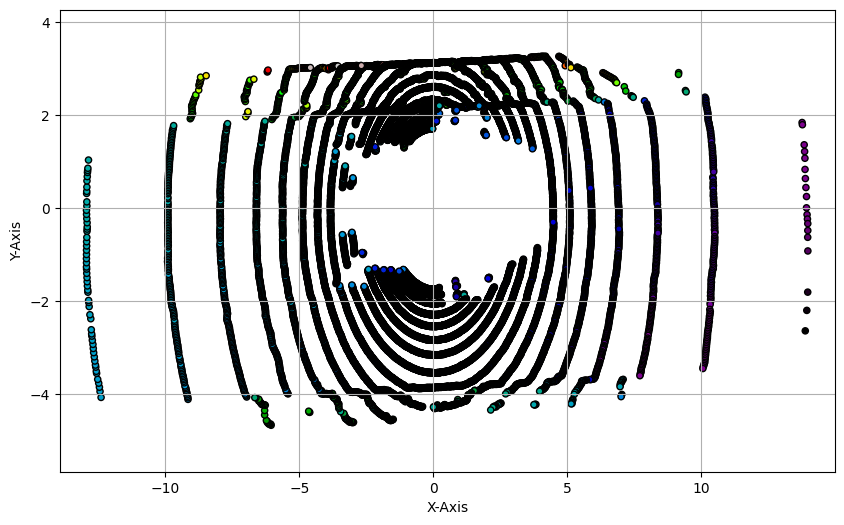

In [43]:
visualize_plane(inlier_nor_cloud, 'xy')